In [1]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install statsmodels
# !pip install scikit-learn
# !pip install pmdarima

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
stock_data = pd.read_csv('INFY.NS.csv',sep=',', index_col='Date', parse_dates=['Date']).fillna(0)
stock_data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-10-01,236.875,239.375000,231.587494,238.168747,168.363663,12118896.0
2007-10-03,240.000,251.862503,238.750000,250.193756,176.864243,26572224.0
2007-10-04,251.250,251.250000,245.250000,249.862503,176.630081,14354928.0
2007-10-05,250.000,250.000000,246.949997,247.862503,175.216248,8433464.0
2007-10-08,250.000,253.125000,248.000000,250.456253,177.049835,8695752.0


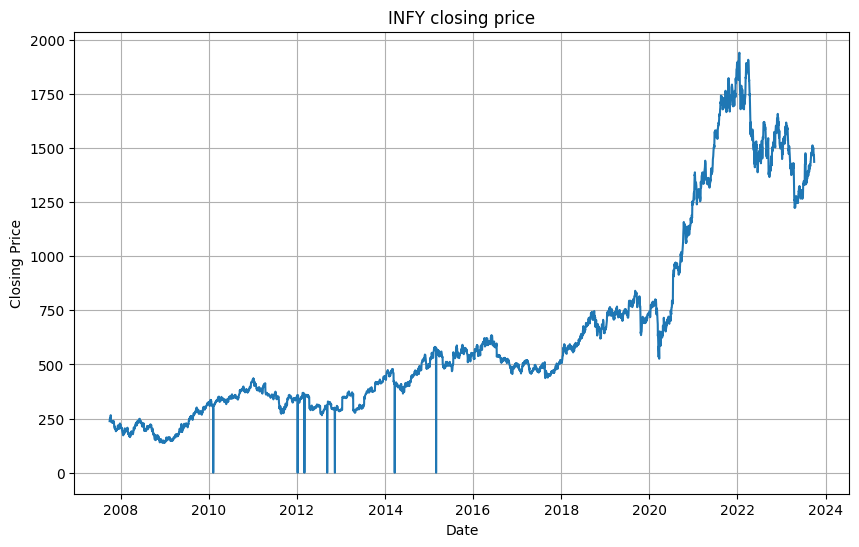

In [4]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(stock_data['Close'])
plt.title('INFY closing price')
plt.show()

<Axes: ylabel='Density'>

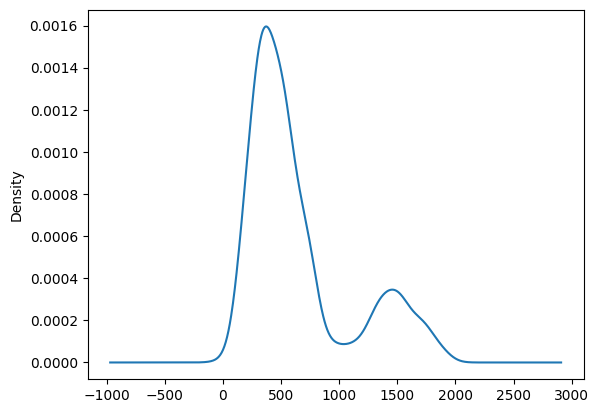

In [5]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

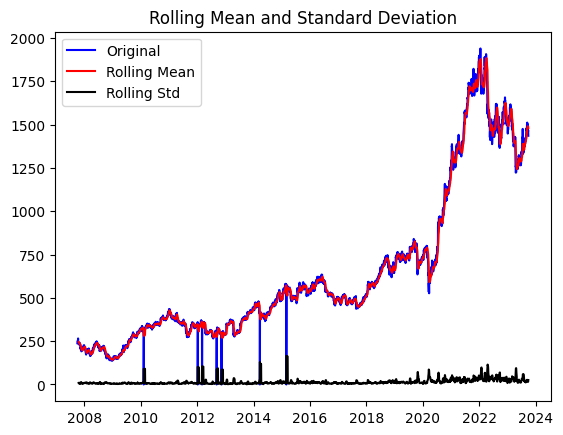

Results of dickey fuller test
Test Statistics                  -0.284631
p-value                           0.927653
No. of lags used                  4.000000
Number of observations used    3947.000000
critical value (1%)              -3.432008
critical value (5%)              -2.862273
critical value (10%)             -2.567160
dtype: float64


In [6]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

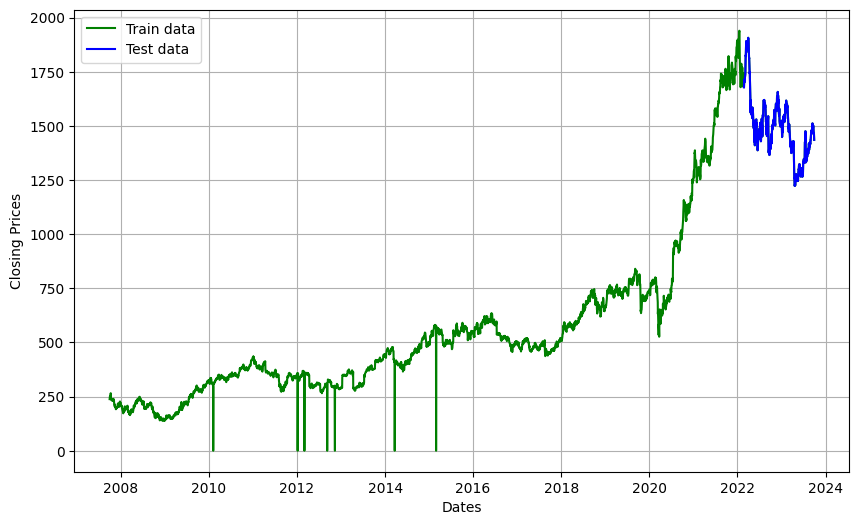

In [7]:
#split data into train and training set
train_data, test_data = df_close[3:int(len(df_close)*0.9)], df_close[int(len(df_close)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33287.903, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32639.080, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32404.141, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33286.818, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=32404.772, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=32404.829, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32405.642, Time=1.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=32407.652, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.567 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3553
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -16199.070
Date:                Mon, 25 Mar 2024   AIC                          32404.141
Time:                       

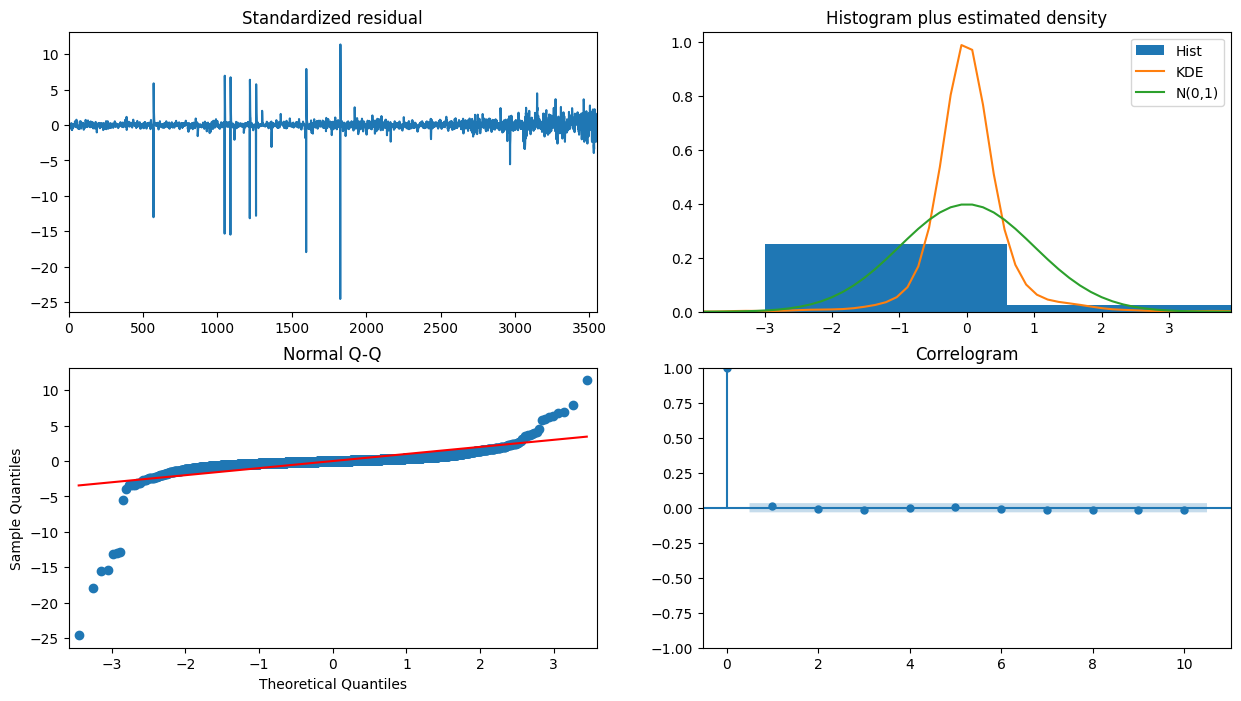

In [8]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

/home/ashwin/Desktop/Stock-analysis/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


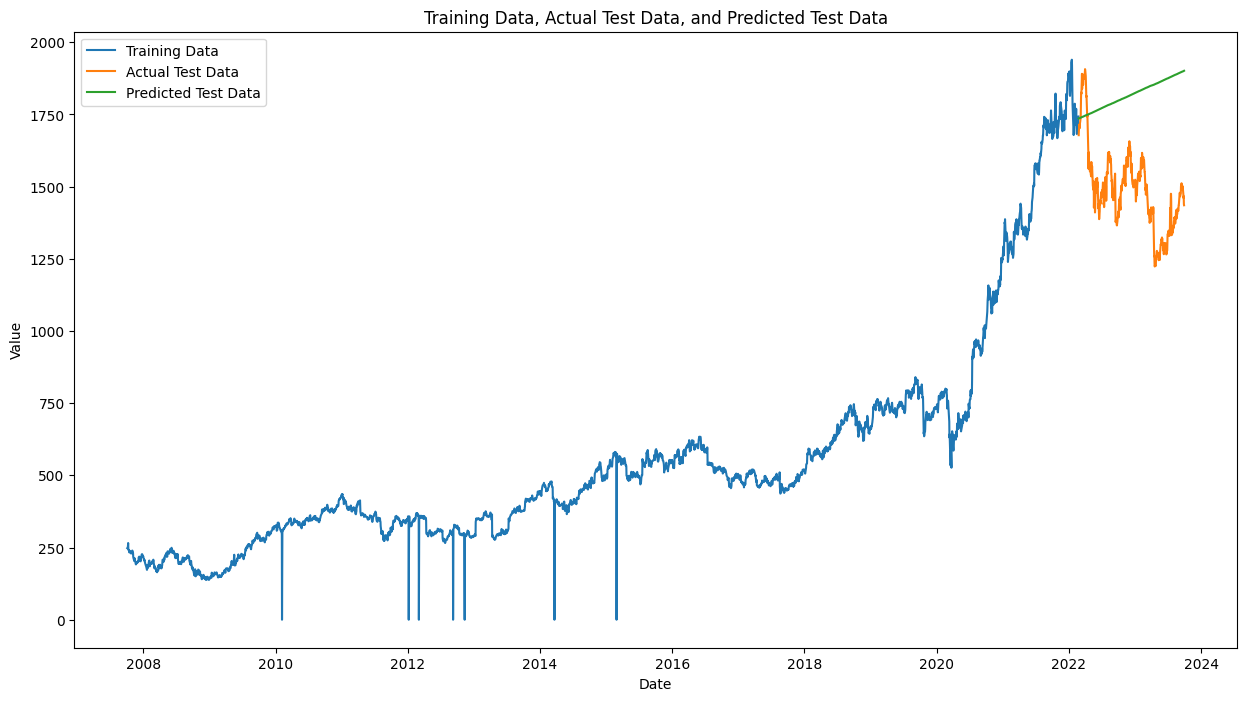

In [9]:
forecast = model_autoARIMA.predict(len(test_data))
plt.figure(figsize=(15, 8))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(test_data.index, forecast, label='Predicted Test Data')

plt.title('Training Data, Actual Test Data, and Predicted Test Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [11]:
# report performance
mse = mean_squared_error(test_data, forecast)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, forecast)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, forecast))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 141286.12881906063
MAE: 345.3732119141277
RMSE: 375.8804714521102
MAPE: nan
